# Nov 22, 2024: individual level estimates
combine all the chains to get partition modes per animal

moved to zaratan `02c-*-indiv-level-estims.*`

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob
from numba import jit
import arviz as az
import random

from itertools import product, combinations
import multiprocessing as mp
from functools import partial

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from munkres import Munkres

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

PARC_DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

In [4]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson-corr'
args.THRESHOLDING = f'positive'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/mouse_dataset/roi_results_v2'
ROI_path = f'{BASE_path}/{PARC_DESC}'
TS_path = f'{ROI_path}/runwise_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLDING}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')

0

In [5]:
args.dc, args.sbm = True, 'h'

args.nested = True if args.sbm in ['h'] else False

args.force_niter = 40000
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-dc-h'

In [6]:
gfile = sorted(glob.glob(f'{GRAPH_path}/*', recursive=True))[0]
g = gt.load_graph(gfile)
g

<Graph object, undirected, with 162 vertices and 2608 edges, 1 internal edge property, at 0x7ff0903a16d0>

In [7]:
def get_pi_matrix(args, mrgnls):
    num_comms = np.max([len(mrgnl) for mrgnl in mrgnls])
    pi = np.zeros((len(mrgnls), num_comms))

    for idx_node, mrgnl in enumerate(mrgnls):
        mrgnl = np.array(mrgnl)
        pi[idx_node, np.where(mrgnl)[0]] = mrgnl[mrgnl > 0]

    pi = pi / np.expand_dims(pi.sum(axis=-1), axis=-1)
    return pi # marginals matrix

In [8]:
def collect_sbm_files(args, sbm_files):
    sbms_df = []
    for file in tqdm(sbm_files):
        with open(file, 'rb') as f:
            [modes] = pickle.load(f)
        
        fs = file.split('/')
        sub = '-'.join([s for s in fs if 'sub-' in s][0].split('-')[1:])
        sbm = [s for s in fs if 'sbm-' in s][0]
        B = [s for s in fs if 'B-' in s][0].split('-')[-1]

        M = np.sum([mode.get_M() for mode in modes])

        for mode_id, mode in enumerate(modes):
            omega = np.round(mode.get_M() / M, 3)
            sigma = np.round(mode.posterior_cdev(), 3)
            ratio = omega / sigma
            ratio = np.round(ratio, 3) if not np.isnan(ratio) else 0.0
            
            mrgnls = mode.get_marginal(g)
            pi = get_pi_matrix(args, mrgnls)
        
            row = pd.DataFrame(dict(
                sub=[sub],
                sbm=[sbm],
                B=[B],
                mode_id=[mode_id],
                mode=[mode],
                omega=[omega],
                sigma=[sigma],
                ratio=[ratio],
                pi=[pi],
            ))
            sbms_df += [row]
        # break
    sbms_df = pd.concat(sbms_df).reset_index(drop=True)
    return sbms_df

sbm_files = sorted(glob.glob(f'{SBM_path}/sub-SLC01/{SBM}/*/desc-partition-modes.pkl', recursive=True))
sbms_df = collect_sbm_files(args, sbm_files)

100%|██████████| 5/5 [07:21<00:00, 88.23s/it]


In [9]:
def sample_partitions(args, sbms_df):
    all_bs_df = []
    for idx, row in tqdm(sbms_df.iterrows()):
        bs = random.sample(
            list(row['mode'].get_partitions().values()), 
            row['num_samples']
        )
        mode_ids = [idx]*len(bs)
        df = pd.DataFrame(dict(
            mode_id=mode_ids,
            b=bs,
        ))
        all_bs_df += [df]
        # all_bs += [
        #   row['mode'].sample_partition(MLE=True) 
        #   for _ in range(row['num_samples'])
        # ]
    all_bs_df = pd.concat(all_bs_df).reset_index(drop=True)
    return all_bs_df

def sample_nested_partitions(args, sbm_dfs):
    all_bs_df = []
    for idx, row in tqdm(sbm_dfs.iterrows()):
        bs = random.sample(
            list(row['mode'].get_nested_partitions().values()), 
            row['num_samples']
        )
        bs = [gt.nested_partition_clear_null(b) for b in bs]
        mode_ids = [idx]*len(bs)
        df = pd.DataFrame(dict(
            mode_id=mode_ids,
            b=bs,
        ))
        all_bs_df += [df]
        # all_bs += [
        #   row['mode'].sample_partition(MLE=True) 
        #   for _ in range(row['num_samples'])
        # ]
    all_bs_df = pd.concat(all_bs_df).reset_index(drop=True)
    return all_bs_df

In [10]:
sbms_df

,sub,sbm,B,mode_id,mode,omega,sigma,ratio,pi
0,SLC01,sbm-dc-h,1,0,<graph_tool.inference.partition_modes.Partitio...,1.000,0.118,8.475,"[[0.39635, 0.0, 0.0, 0.0, 0.0, 0.5291, 0.07435..."
1,SLC01,sbm-dc-h,122,0,<graph_tool.inference.partition_modes.Partitio...,0.394,0.044,8.955,"[[0.0, 0.0, 0.0, 0.0, 0.5286276501206043, 0.0,..."
2,SLC01,sbm-dc-h,122,1,<graph_tool.inference.partition_modes.Partitio...,0.177,0.091,1.945,"[[0.25346927216086096, 0.0, 0.0, 0.0, 0.175587..."
3,SLC01,sbm-dc-h,122,2,<graph_tool.inference.partition_modes.Partitio...,0.152,0.076,2.000,"[[0.6037487668530089, 0.0, 0.0, 0.0, 0.1456757..."
4,SLC01,sbm-dc-h,122,3,<graph_tool.inference.partition_modes.Partitio...,0.126,0.097,1.299,"[[0.15847860538827258, 0.0, 0.0, 0.0, 0.157686..."
5,SLC01,sbm-dc-h,122,4,<graph_tool.inference.partition_modes.Partitio...,0.118,0.065,1.815,"[[0.16503615482773287, 0.0, 0.0, 0.0, 0.142492..."
6,SLC01,sbm-dc-h,122,5,<graph_tool.inference.partition_modes.Partitio...,0.034,0.095,0.358,"[[0.5712166172106825, 0.0, 0.0, 0.0, 0.4287833..."
7,SLC01,sbm-dc-h,122,6,<graph_tool.inference.partition_modes.Partitio...,0.000,0.040,0.000,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,SLC01,sbm-dc-h,162,0,<graph_tool.inference.partition_modes.Partitio...,0.721,0.043,16.767,"[[0.5396242113291271, 0.0, 0.0, 0.0, 0.4603757..."
9,SLC01,sbm-dc-h,162,1,<graph_tool.inference.partition_modes.Partitio...,0.116,0.090,1.289,"[[0.6777251184834123, 0.0, 0.0, 0.0, 0.1266695..."


---
1. **modes per animals**
2. sample partitions from each chain per mode, 
3. collect all of them into `PartitionModeState()` to align them,
4. find clusters with `ModeClusterState()` using the aligned partitions

In [11]:
args.total_samples = 1000
sbms_df['num_samples'] = sbms_df['omega'].apply(lambda x: np.round(x * args.total_samples).astype(int))
if args.sbm in ['a', 'd']:
    all_bs_df = sample_partitions(args, sbms_df)
if args.sbm in ['h']:
    all_bs_df = sample_nested_partitions(args, sbms_df)
print(len(all_bs_df))
all_bs_df.head(n=8)

23it [00:22,  1.01it/s]

5002


,mode_id,b
0,0.0,"[[0, 1, 1, 3, 3, 0, 4, 0, 5, 4, 0, 1, 5, 0, 0,..."
1,0.0,"[[5, 1, 1, 2, 3, 0, 4, 0, 5, 4, 6, 1, 5, 0, 0,..."
2,0.0,"[[0, 1, 1, 2, 3, 0, 4, 0, 5, 4, 6, 1, 5, 0, 0,..."
3,0.0,"[[5, 1, 1, 3, 3, 0, 4, 0, 5, 4, 0, 1, 5, 0, 0,..."
4,0.0,"[[0, 1, 1, 3, 3, 0, 4, 0, 5, 4, 0, 1, 5, 0, 0,..."
5,0.0,"[[5, 1, 1, 2, 3, 0, 4, 0, 5, 4, 6, 1, 5, 0, 0,..."
6,0.0,"[[5, 1, 1, 3, 3, 0, 4, 0, 5, 4, 0, 1, 5, 0, 0,..."
7,0.0,"[[5, 1, 1, 2, 3, 0, 4, 0, 5, 4, 0, 1, 5, 0, 0,..."


In [19]:
# align all samples iteratively until the labels converge
pmode = gt.PartitionModeState(all_bs_df['b'], relabel=True, nested=args.nested, converge=False)
ent_diff = -np.inf
while ent_diff < 1e-10:
    ed = pmode.replace_partitions()
    print(ed)
    if np.isclose(ed, ent_diff, rtol=1e-10):
        break
    ent_diff = ed

-1294.9975880556876
-13.087472875790965
-2.7381519786648667
-0.8713270087904377
-0.10329325077002238
-0.005701296974933712
-0.06162538751718927
-0.03996082766228426
-0.4164593159524941
-5.001596292686372e-08
-5.001596292686372e-08


In [20]:
if args.sbm in ['a', 'd']:
    bs = pmode.get_partitions()
if args.sbm in ['h']:
    bs = pmode.get_nested_partitions()
bs = {k:v for k, v in sorted(bs.items())}
all_bs_df['b_aligned'] = list(bs.values())
all_bs_df

,mode_id,b,b_aligned
0,0.0,"[[0, 1, 1, 3, 3, 0, 4, 0, 5, 4, 0, 1, 5, 0, 0,...","[[0, 1, 1, 2, 2, 0, 3, 0, 4, 3, 0, 1, 4, 0, 0,..."
1,0.0,"[[5, 1, 1, 2, 3, 0, 4, 0, 5, 4, 6, 1, 5, 0, 0,...","[[4, 1, 1, 2, 14, 15, 3, 15, 4, 3, 0, 1, 4, 15..."
2,0.0,"[[0, 1, 1, 2, 3, 0, 4, 0, 5, 4, 6, 1, 5, 0, 0,...","[[15, 1, 1, 2, 14, 15, 3, 15, 4, 3, 0, 1, 4, 1..."
3,0.0,"[[5, 1, 1, 3, 3, 0, 4, 0, 5, 4, 0, 1, 5, 0, 0,...","[[4, 1, 1, 2, 2, 0, 3, 0, 4, 3, 0, 1, 4, 0, 0,..."
4,0.0,"[[0, 1, 1, 3, 3, 0, 4, 0, 5, 4, 0, 1, 5, 0, 0,...","[[0, 1, 1, 2, 2, 0, 3, 0, 4, 3, 0, 1, 4, 0, 0,..."
...,...,...,...
4997,22.0,"[[4, 1, 1, 2, 3, 4, 5, 4, 0, 5, 4, 1, 0, 4, 4,...","[[15, 1, 1, 2, 14, 15, 3, 15, 4, 3, 15, 1, 4, ..."
4998,22.0,"[[6, 1, 1, 2, 3, 4, 5, 4, 0, 5, 6, 1, 0, 4, 4,...","[[0, 1, 1, 2, 14, 15, 3, 15, 4, 3, 0, 1, 4, 15..."
4999,22.0,"[[0, 1, 1, 2, 3, 4, 5, 4, 0, 5, 6, 1, 0, 4, 4,...","[[4, 1, 1, 2, 14, 15, 3, 15, 4, 3, 0, 1, 4, 15..."
5000,22.0,"[[0, 1, 1, 2, 3, 4, 5, 4, 0, 5, 6, 1, 0, 4, 4,...","[[4, 1, 1, 2, 14, 15, 3, 15, 4, 3, 0, 1, 4, 15..."


In [21]:
pis_df = []
for key, group in tqdm(all_bs_df.groupby(by='mode_id')):
    pm = gt.PartitionModeState(bs=group['b_aligned'], relabel=False, nested=args.nested, converge=False)
    mrgnls = pm.get_marginal(g)
    pi = get_pi_matrix(args, mrgnls)
    df = pd.DataFrame(dict(
        mode_id=[key],
        pi=[pi],
    ))
    pis_df += [df]
    # break
pis_df = pd.concat(pis_df).reset_index(drop=True)

100%|██████████| 21/21 [00:23<00:00,  1.10s/it]


In [22]:
pis_df.head(n=3)

,mode_id,pi
0,0.0,"[[0.448, 0.0, 0.0, 0.0, 0.495, 0.0, 0.0, 0.0, ..."
1,1.0,"[[0.5228426395939086, 0.0, 0.0, 0.0, 0.4771573..."
2,2.0,"[[0.2824858757062147, 0.0, 0.0, 0.0, 0.5367231..."


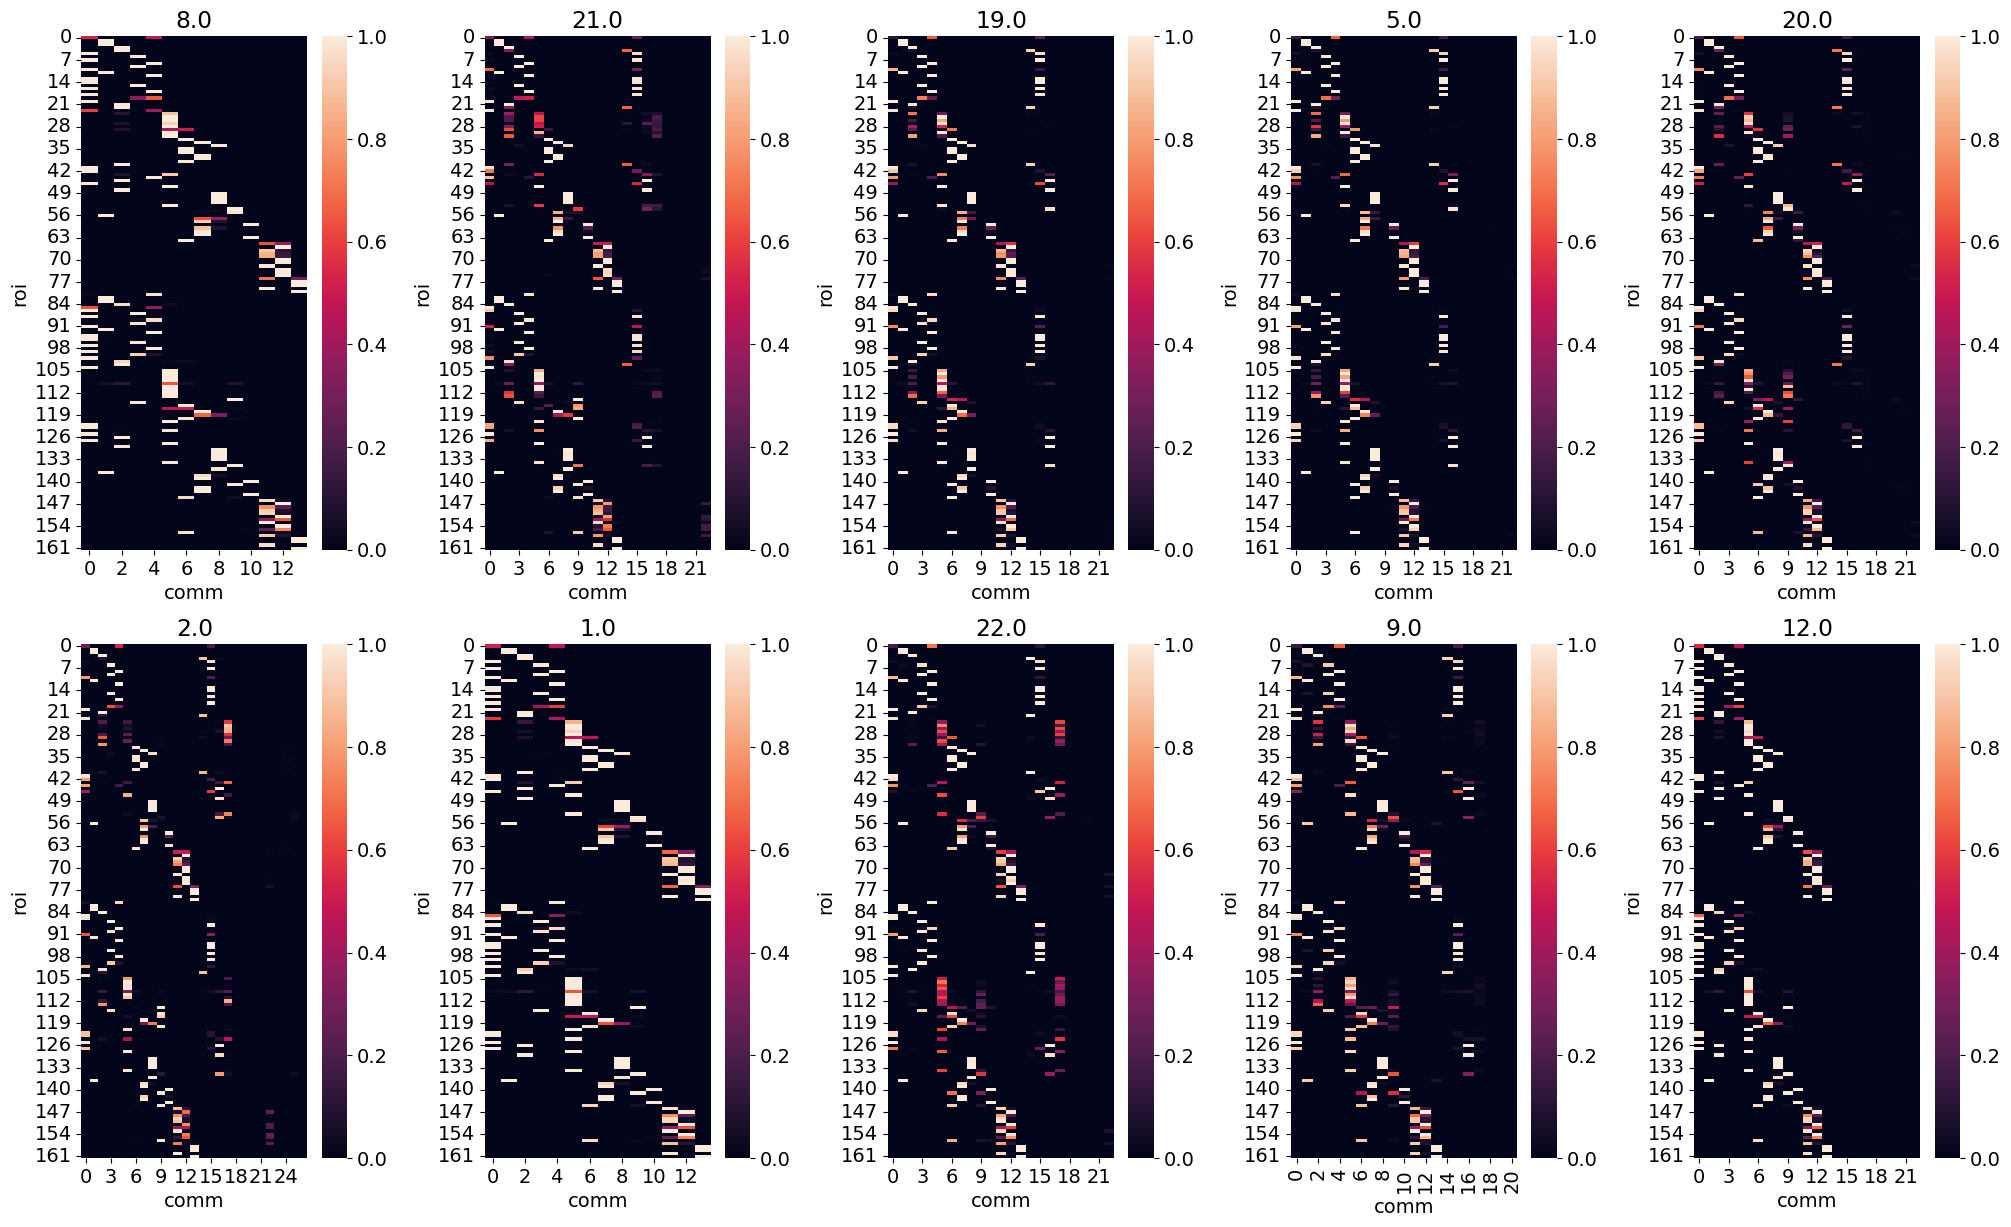

In [23]:
ncols = 5
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 6*nrows))
fig.tight_layout(h_pad=3, w_pad=3)
mode_ids = random.sample(list(pis_df['mode_id'].unique()), k=10)
for idx in range(nrows * ncols):
    mode_id = mode_ids[idx]
    pi = pis_df[pis_df['mode_id'] == mode_id]['pi'].to_list()[0]    
    ax = axs[idx // ncols, idx % ncols]
    sns.heatmap(pi, ax=ax)
    ax.set(title=f'{mode_id}', xlabel=f'comm', ylabel=f'roi')

In [41]:
def posterior_modes(args, bs):
    cmode = gt.ModeClusterState(bs, nested=args.nested, relabel=False)
    gt.mcmc_equilibrate(cmode, wait=1, mcmc_args=dict(niter=1, beta=np.inf))
    cmode.relabel(maxiter=1000)
    return cmode

In [42]:
cmode = posterior_modes(args, all_bs_df['b_aligned'].to_list())

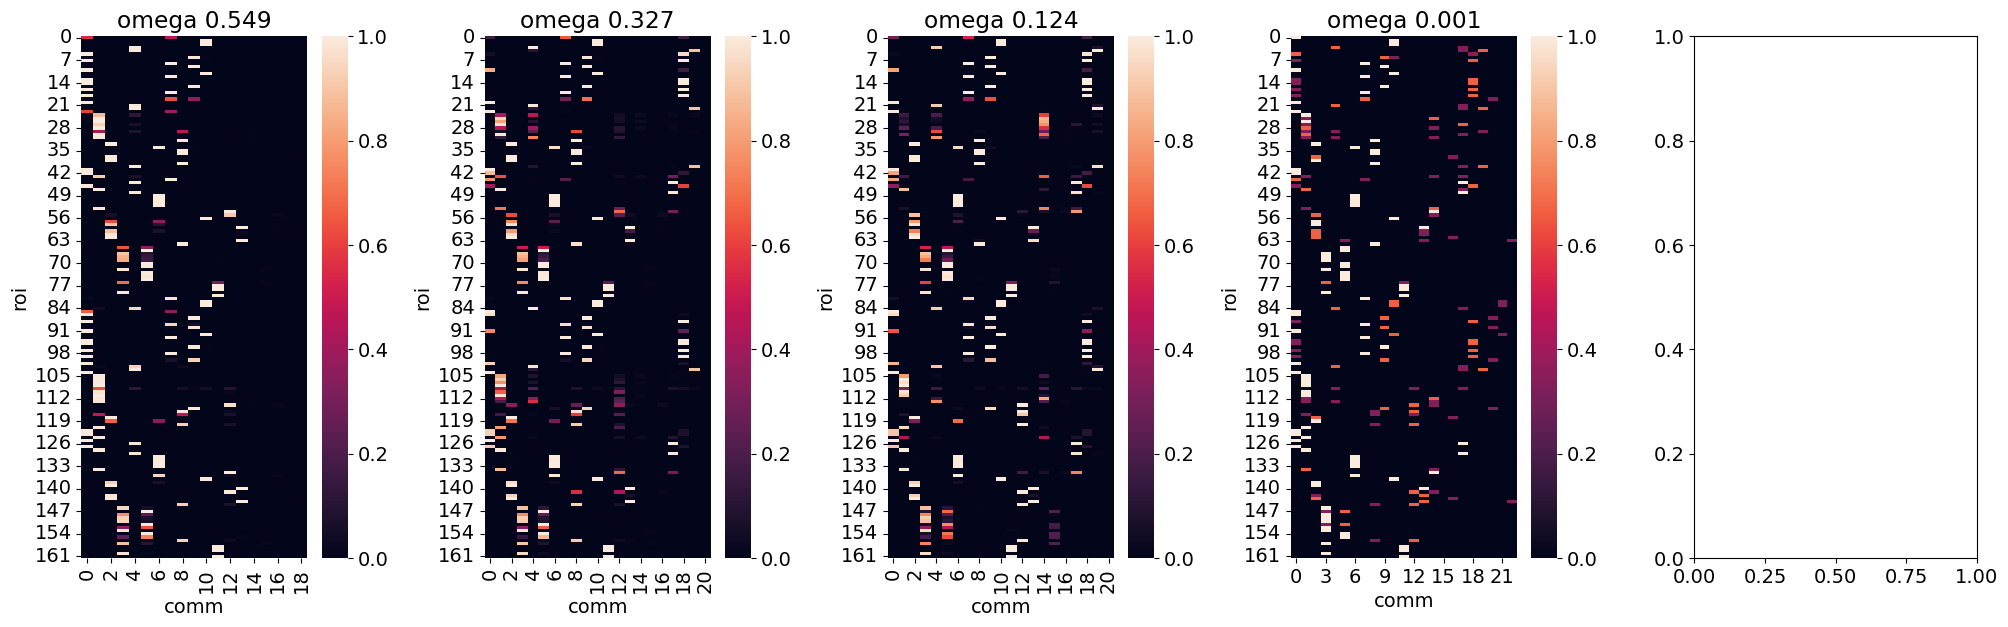

In [43]:
modes = cmode.get_modes()
pis = [get_pi_matrix(args, mode.get_marginal(g))  for mode in modes]
M = np.sum([mode.get_M() for mode in modes])
omegas = [mode.get_M() / M for mode in modes]
modes_df = pd.DataFrame(dict(mode_id=np.arange(len(pis)), pi=pis, omega=omegas))

ncols = 5
nrows = np.ceil(len(pis) / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 6*nrows))
fig.tight_layout(h_pad=3, w_pad=3)
for idx, (pi, omega) in enumerate(zip(pis, omegas)):
    ax = axs[idx // ncols, idx % ncols] if nrows > 1 else axs[idx % ncols]
    sns.heatmap(pi, ax=ax, )
    ax.set(title=f'omega {np.round(omega, 3)}', xlabel=f'comm', ylabel=f'roi')

(162, 4, 23)


<Axes: >

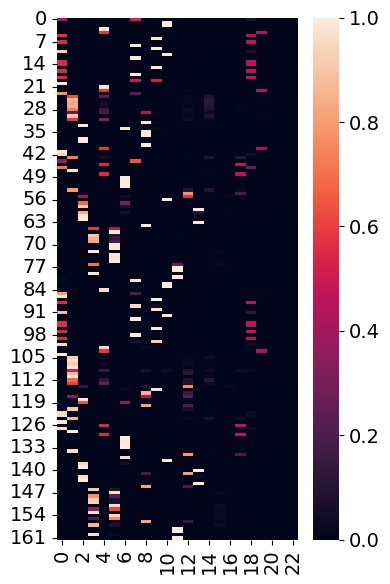

In [44]:
def get_membership_matrix(args, df):
    num_modes = len(df)
    num_comms = np.max(df['pi'].apply(lambda pi: pi.shape[-1]))
    num_rois = df.iloc[0]['pi'].shape[0]
    M = np.zeros((num_rois, num_modes, num_comms)) # membership profile matrix

    for idx_mode in range(num_modes):
        pi = df[df['mode_id'] == idx_mode]['pi'].to_list()[0]
        M[:, idx_mode, :pi.shape[-1]] = pi
    return M

M = get_membership_matrix(args, modes_df)
print(M.shape)

soft_comms = np.average(M, axis=1, weights=omegas)
fig, axs = plt.subplots(1, 1, figsize=(4, 6))
fig.tight_layout(h_pad=3, w_pad=3)
ax = axs
sns.heatmap(soft_comms, ax=ax, )#cmap=cc.cm.CET_L12)

In [32]:
np.round(soft_comms[19, :], 3)

array([0.   , 0.   , 0.   , 0.51 , 0.489, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   ])

---

In [23]:
def reference_comms(args, X):
    X = np.concatenate(X, axis=-1)
    kmeans = KMeans(
        n_clusters=args.num_comms, 
        init='k-means++', n_init=50,
        random_state=args.SEED
    ).fit(X=X.T)
    print('found reference')
    return kmeans.cluster_centers_.T # num_rois x num_comms

def align_two_partitions(args, source_comms, target_comms):
    # align source onto target
    
    # distatnce matrix
    D = 1 - cosine_similarity(target_comms.T, source_comms.T)
    # Hungarian permutation method
    best_pi = list(zip(*Munkres().compute(D)))[1]
    source_comms = source_comms[:, best_pi]
    return source_comms, best_pi

def align_partitions(args, X):
    comm_cntrs = reference_comms(args, X)
    
    for idx, comms in tqdm(enumerate(X)):
        (
            comms, 
            best_pi,
        ) = align_two_partitions(
            args, 
            source_comms=comms, 
            target_comms=comm_cntrs
        )
        X[idx] = comms * (comms > args.thresh)
        X[idx] = np.round(X[idx], decimals=3)
    return X

In [47]:
Xs = [np.squeeze(X) for X in np.split(M, M.shape[1], axis=1)]
args.thresh = 0.1
args.num_comms = Xs[0].shape[1]
Xs = align_partitions(args, Xs)
M = np.stack(Xs, axis=1)
M.shape

found reference


4it [00:00, 59.80it/s]


(162, 4, 25)

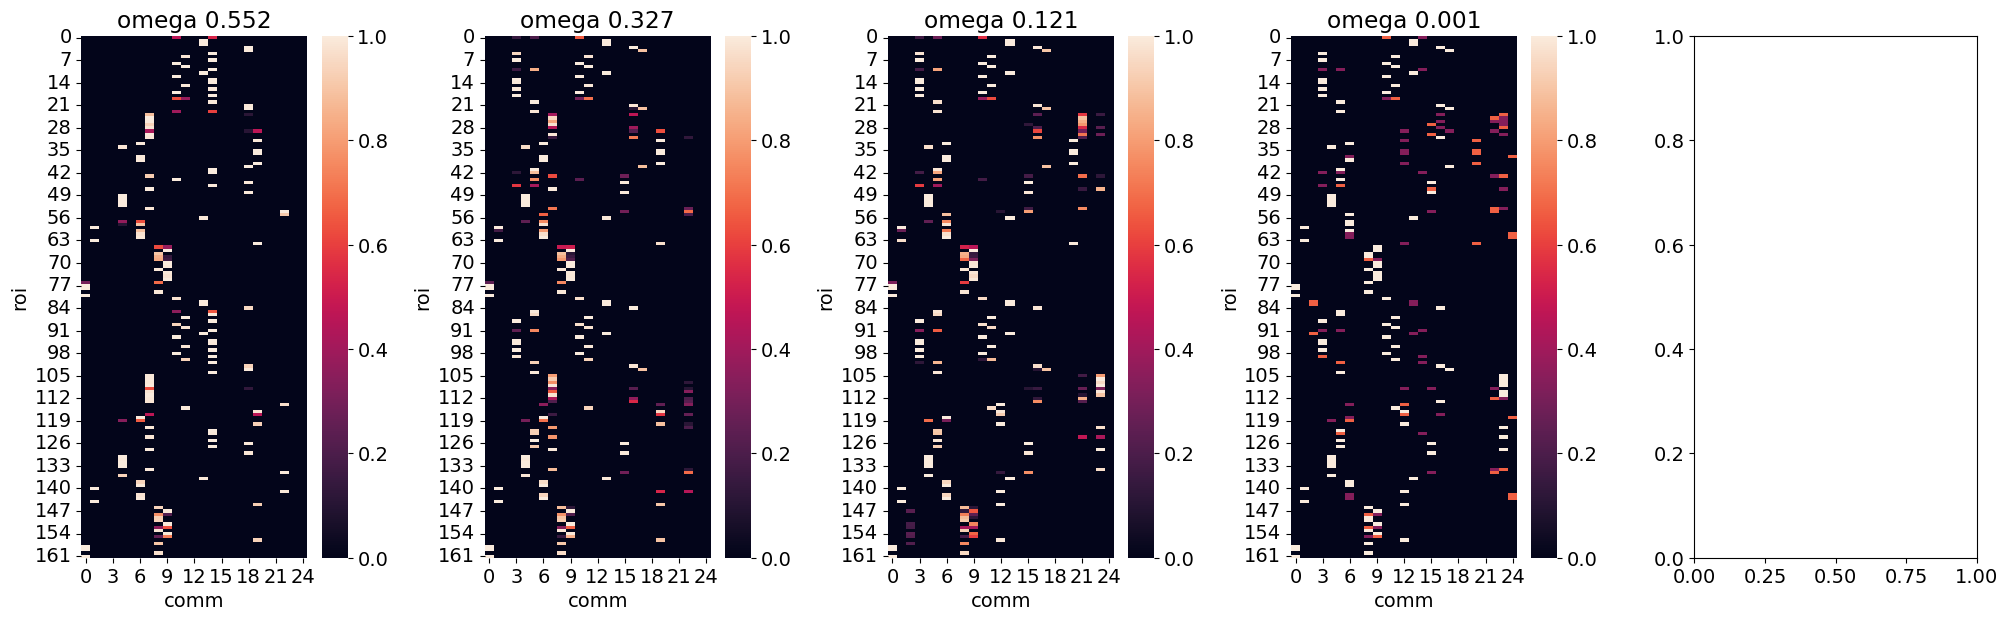

In [48]:
ncols = 5
nrows = np.ceil(len(pis) / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 6*nrows))
fig.tight_layout(h_pad=3, w_pad=3)
for idx, (pi, omega) in enumerate(zip(Xs, omegas)):
    ax = axs[idx // ncols, idx % ncols] if nrows > 1 else axs[idx % ncols]
    sns.heatmap(pi, ax=ax, )
    ax.set(title=f'omega {np.round(omega, 3)}', xlabel=f'comm', ylabel=f'roi')

<Axes: >

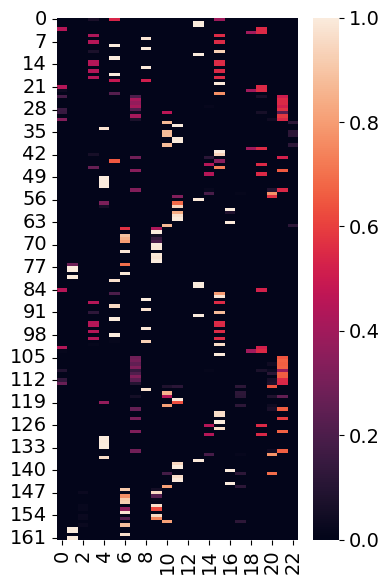

In [26]:
soft_comms_ = np.average(M, axis=1, weights=omegas)
fig, axs = plt.subplots(1, 1, figsize=(4, 6))
fig.tight_layout(h_pad=3, w_pad=3)
ax = axs
sns.heatmap(soft_comms_, ax=ax, )#cmap=cc.cm.CET_L12)

In [27]:
np.round(soft_comms_[19, :], 3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.487, 0.   , 0.   , 0.512,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   ])